In [7]:
import json
import os
import random

import pandas as pd
import torch
import torch.nn as nn
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data explore
data_dir = "./Data_n"
dir_list = os.listdir(data_dir)
dir_list.sort(reverse=True)
print(dir_list)

['data_9.json', 'data_8.json', 'data_7.json', 'data_6.json', 'data_5.json', 'data_4.json', 'data_3.json', 'data_2.json', 'data_1.json']


In [3]:
area_names = []
area_codes = []
dates = []
new_Vaccins = []
cum_Vaccins = []
reg_pop = []

for data_path in dir_list[:-1]:

    dt_js = json.load(open(os.path.join(data_dir, data_path), 'r', encoding='utf-8'))
    for date_data in dt_js['data']:
        #print(date_data['date'])
        area_names.append(date_data['areaName'])
        area_codes.append(date_data['areaCode'])
        dates.append(date_data['date'])

        new = 0
        cum = 0
        reg = 0
        for age_data in date_data['vaccinationsAgeDemographics']:
            if age_data['age'] == '50+' or age_data['age'] == '75+':
                continue
            '''reg += age_data['VaccineRegisterPopulationByVaccinationDate']
            cum += age_data['cumPeopleVaccinatedFirstDoseByVaccinationDate']
            new += age_data['newPeopleVaccinatedFirstDoseByVaccinationDate']'''

            reg += age_data['cumPeopleVaccinatedFirstDoseByVaccinationDate']
            cum += age_data['cumPeopleVaccinatedSecondDoseByVaccinationDate']
            new += age_data['newPeopleVaccinatedSecondDoseByVaccinationDate']
        new_Vaccins.append(new)
        cum_Vaccins.append(cum)
        reg_pop.append(reg)

Data_df = pd.DataFrame({
    'name': area_names,
    'code': area_codes,
    'date': dates,
    'reg': reg_pop,
    'cum': cum_Vaccins,
    'new': new_Vaccins
})
Data_df

,name,code,date,reg,cum,new
0,Yorkshire and The Humber,E12000003,2023-01-11,4256995.0,4052502.0,76.0
1,Yorkshire and The Humber,E12000003,2023-01-10,4256957.0,4052426.0,49.0
2,Yorkshire and The Humber,E12000003,2023-01-09,4256916.0,4052377.0,28.0
3,Yorkshire and The Humber,E12000003,2023-01-08,4256898.0,4052349.0,115.0
4,Yorkshire and The Humber,E12000003,2023-01-07,4256842.0,4052234.0,194.0
...,...,...,...,...,...,...
6115,East of England,E12000006,2020-12-12,6283.0,394.0,0.0
6116,East of England,E12000006,2020-12-11,5149.0,394.0,1.0
6117,East of England,E12000006,2020-12-10,3628.0,393.0,0.0
6118,East of England,E12000006,2020-12-09,2032.0,393.0,0.0


In [8]:
data_sp = Data_df
regions_id = list(set(list(data_sp['code'])))
regions_id.sort()
data_region = {}  # 截取每个reigon的data，加入字典里面，每个都由新增和积累两部分
for id in regions_id:
    data_region[id] = data_sp[data_sp["code"] == id]
data_region[regions_id[0]]

,name,code,date,reg,cum,new
3825,North East,E12000001,2023-01-11,2107351.0,2004174.0,20.0
3826,North East,E12000001,2023-01-10,2107339.0,2004154.0,21.0
3827,North East,E12000001,2023-01-09,2107317.0,2004133.0,5.0
3828,North East,E12000001,2023-01-08,2107312.0,2004128.0,16.0
3829,North East,E12000001,2023-01-07,2107301.0,2004112.0,14.0
...,...,...,...,...,...,...
4585,North East,E12000001,2020-12-12,2913.0,486.0,0.0
4586,North East,E12000001,2020-12-11,2748.0,486.0,1.0
4587,North East,E12000001,2020-12-10,2215.0,485.0,7.0
4588,North East,E12000001,2020-12-09,1619.0,478.0,7.0


In [9]:
regions_name = {}
for id in regions_id:
    regions_name[id] = list(data_region[id]['name'])[0]
regions_name

{'E12000001': 'North East',
 'E12000002': 'North West',
 'E12000003': 'Yorkshire and The Humber',
 'E12000005': 'West Midlands',
 'E12000006': 'East of England',
 'E12000007': 'London',
 'E12000008': 'South East',
 'E12000009': 'South West'}

In [10]:
#对新增和累计求    7日平均
for id in regions_id:
    for i in range(data_region[id].shape[0] - 6):
        #print(data_region[id].iloc[i:i + 7, 2].sum() / 7.0)
        #print(data_region[id].iloc[i:i + 7, 3].sum() / 7.0)
        data_region[id].iloc[i, 4] = data_region[id].iloc[i:i + 7, 4].sum() / 7.0
        data_region[id].iloc[i, 5] = data_region[id].iloc[i:i + 7, 5].sum() / 7.0
    data_region[id] = data_region[id].iloc[:-6]
data_region[regions_id[0]]

,name,code,date,reg,cum,new
3825,North East,E12000001,2023-01-11,2107351.0,2.004120e+06,20.428571
3826,North East,E12000001,2023-01-10,2107339.0,2.004100e+06,22.285714
3827,North East,E12000001,2023-01-09,2107317.0,2.004078e+06,26.000000
3828,North East,E12000001,2023-01-08,2107312.0,2.004052e+06,25.714286
3829,North East,E12000001,2023-01-07,2107301.0,2.004026e+06,23.571429
...,...,...,...,...,...,...
4579,North East,E12000001,2020-12-18,17010.0,4.994286e+02,4.714286
4580,North East,E12000001,2020-12-17,13754.0,4.947143e+02,3.857143
4581,North East,E12000001,2020-12-16,10040.0,4.908571e+02,3.857143
4582,North East,E12000001,2020-12-15,6323.0,4.870000e+02,3.571429


In [11]:
#fig, axes = plt.subplots(5, 2, figsize=(25, 40))
#axes = axes.reshape((-1))
gamma = np.zeros(len(regions_id))
scores = []
epochs = 1
for e in range(epochs):
    print(e)
    for i, id in enumerate(regions_id):
        df = data_region[id]
        df = df.iloc[::-1]
        X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
        y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

        LR = LinearRegression(fit_intercept=False)
        LR.fit(X, y)

        sc = LR.score(X, y)
        y_pred = LR.predict(X)

        y_derta = y_pred - y
        X_derta = np.array(df['cum']).reshape((-1, 1))
        LR_derta = LinearRegression(fit_intercept=False)
        LR_derta.fit(X_derta, y_derta)
        gamma[i] = LR_derta.coef_[0][0]
        #print('gamma:', LR_derta.coef_)
        #print('score:', sc)
        X_derta = X_derta.reshape((-1))
        y_derta = y_derta.reshape((-1))
        print(regions_name[id], pearsonr(X_derta, y_derta))
        scores.append(sc)


0
North East PearsonRResult(statistic=0.21872163862120197, pvalue=1.1310630991924513e-09)
North West PearsonRResult(statistic=0.23279655030059868, pvalue=8.449742521259661e-11)
Yorkshire and The Humber PearsonRResult(statistic=0.218904530500316, pvalue=1.0947709657587473e-09)
West Midlands PearsonRResult(statistic=0.2281493793062293, pvalue=2.028073176902689e-10)
East of England PearsonRResult(statistic=0.22275904901490434, pvalue=5.469135945244661e-10)
London PearsonRResult(statistic=0.20489837025108015, pvalue=1.2252230487578863e-08)
South East PearsonRResult(statistic=0.2118982580904191, pvalue=3.741448079607218e-09)
South West PearsonRResult(statistic=0.22418773282996102, pvalue=4.214937884595067e-10)


In [12]:
gamma = np.zeros(len(regions_id))
gammas = [1 / 7, 1 / 14, 1 / 21, 1 / 30, 1 / 90, 1 / (30 * 6), 1 / (30 * 9), 1 / (30 * 12), 1 / (30 * 18),
          1 / (30 * 24), 1 / (30 * 30), 1 / (30 * 36), 1 / (30 * 42)]
sc_d = []
gam = gammas[-1]
r0_s = []
sc_sir = []
for gam in gammas:
    sc_sir = []
    for i, id in enumerate(regions_id):
        df = data_region[id]
        df = df.iloc[::-1]

        gamma = np.ones(len(regions_id)) * gam

        X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
        y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

        LR = LinearRegression(fit_intercept=False)
        LR.fit(X, y)

        sc = LR.score(X, y)
        sc_sir.append(sc)
        y_pred = LR.predict(X)
        y_pred -= gamma[i] * np.array(df['cum']).reshape((-1, 1))
        #y -= gamma[i] * np.array(df['cum']).reshape((-1, 1))

        #gammas.append(LR.coef_)

        '''plt.plot(range(len(df)), y, label='ture vaccination')
        plt.plot(range(len(df)), y_pred, label='predicted vaccination')
        plt.title(regions_name[id])
        plt.legend()
        plt.show()
        plt.plot(range(len(df)), y, label='ture vaccination')
        plt.plot(range(len(df)), y_pred, label='predicted vaccination')
        plt.title(regions_name[id])
        plt.legend()
        plt.show()'''
        r0_s.append(LR.coef_)
    sc_d.append(np.mean(np.array(sc_sir)))

In [14]:
t=pd.DataFrame({
    'gamma':gammas,
    'r2_score':sc_d
}).to_latex()

pd.DataFrame({
    'gamma':gammas,
    'r2_score':sc_d
})

,gamma,r2_score
0,0.142857,-4.466970
1,0.071429,-4.714211
2,0.047619,-4.959201
3,0.033333,-5.265951
4,0.011111,-6.606886
5,0.005556,-5.669922
6,0.003704,-3.980641
7,0.002778,-2.871359
8,0.001852,-1.783368
9,0.001389,-1.305740


In [19]:
gamma = np.zeros(len(regions_id))
gammas = [1 / 7, 1 / 14, 1 / 21, 1 / 30, 1 / 90, 1 / (30 * 6), 1 / (30 * 9), 1 / (30 * 12), 1 / (30 * 18),
          1 / (30 * 24), 1 / (30 * 30), 1 / (30 * 36), 1 / (30 * 42)]
sc_d = []
gam = gammas[-1]
r0_s = []
sc_sir = []
for i, id in enumerate(regions_id):
    df = data_region[id]
    df = df.iloc[::-1]

    gamma = np.ones(len(regions_id)) * gam

    X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
    y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

    LR = LinearRegression(fit_intercept=False)
    LR.fit(X, y)

    sc = LR.score(X, y)
    sc_sir.append(sc)
    y_pred = LR.predict(X)
    y_pred -= gamma[i] * np.array(df['cum']).reshape((-1, 1))
    #y -= gamma[i] * np.array(df['cum']).reshape((-1, 1))

    #gammas.append(LR.coef_)

    '''plt.plot(range(len(df)), y, label='ture vaccination')
    plt.plot(range(len(df)), y_pred, label='predicted vaccination')
    plt.title(regions_name[id])
    plt.legend()
    plt.show()
    plt.plot(range(len(df)), y, label='ture vaccination')
    plt.plot(range(len(df)), y_pred, label='predicted vaccination')
    plt.title(regions_name[id])
    plt.legend()
    plt.show()'''
    r0_s.append(LR.coef_)

In [20]:
mns = [regions_name[id] for id in regions_id]
r0_s = [x[0][0] for x in r0_s]

t = pd.DataFrame({
    'name': mns,
    'gamma': r0_s
}).to_latex()

pd.DataFrame({
    'name': mns,
    'gamma': r0_s
})

,name,gamma
0,North East,0.000276
1,North West,0.000233
2,Yorkshire and The Humber,0.000262
3,West Midlands,0.000196
4,East of England,0.000224
5,London,0.000374
6,South East,0.000278
7,South West,0.000225


In [21]:
mns = [regions_name[id] for id in regions_id]
sc_s = [x for x in sc_sir]
t = pd.DataFrame({
    'name': mns,
    'gamma': sc_sir
}).to_latex()

pd.DataFrame({
    'name': mns,
    'gamma': sc_sir
})

,name,gamma
0,North East,-0.761711
1,North West,-0.776564
2,Yorkshire and The Humber,-0.772172
3,West Midlands,-0.756159
4,East of England,-0.760573
5,London,-0.980089
6,South East,-0.808582
7,South West,-0.726847


In [22]:
mns = [regions_name[id] for id in regions_id]
gamma_ = [x[0][0] for x in gammas]

t = pd.DataFrame({
    'name': mns,
    'gamma': gamma_
}).to_latex()

pd.DataFrame({
    'name': mns,
    'gamma': gamma_
})

TypeError: 'float' object is not subscriptable

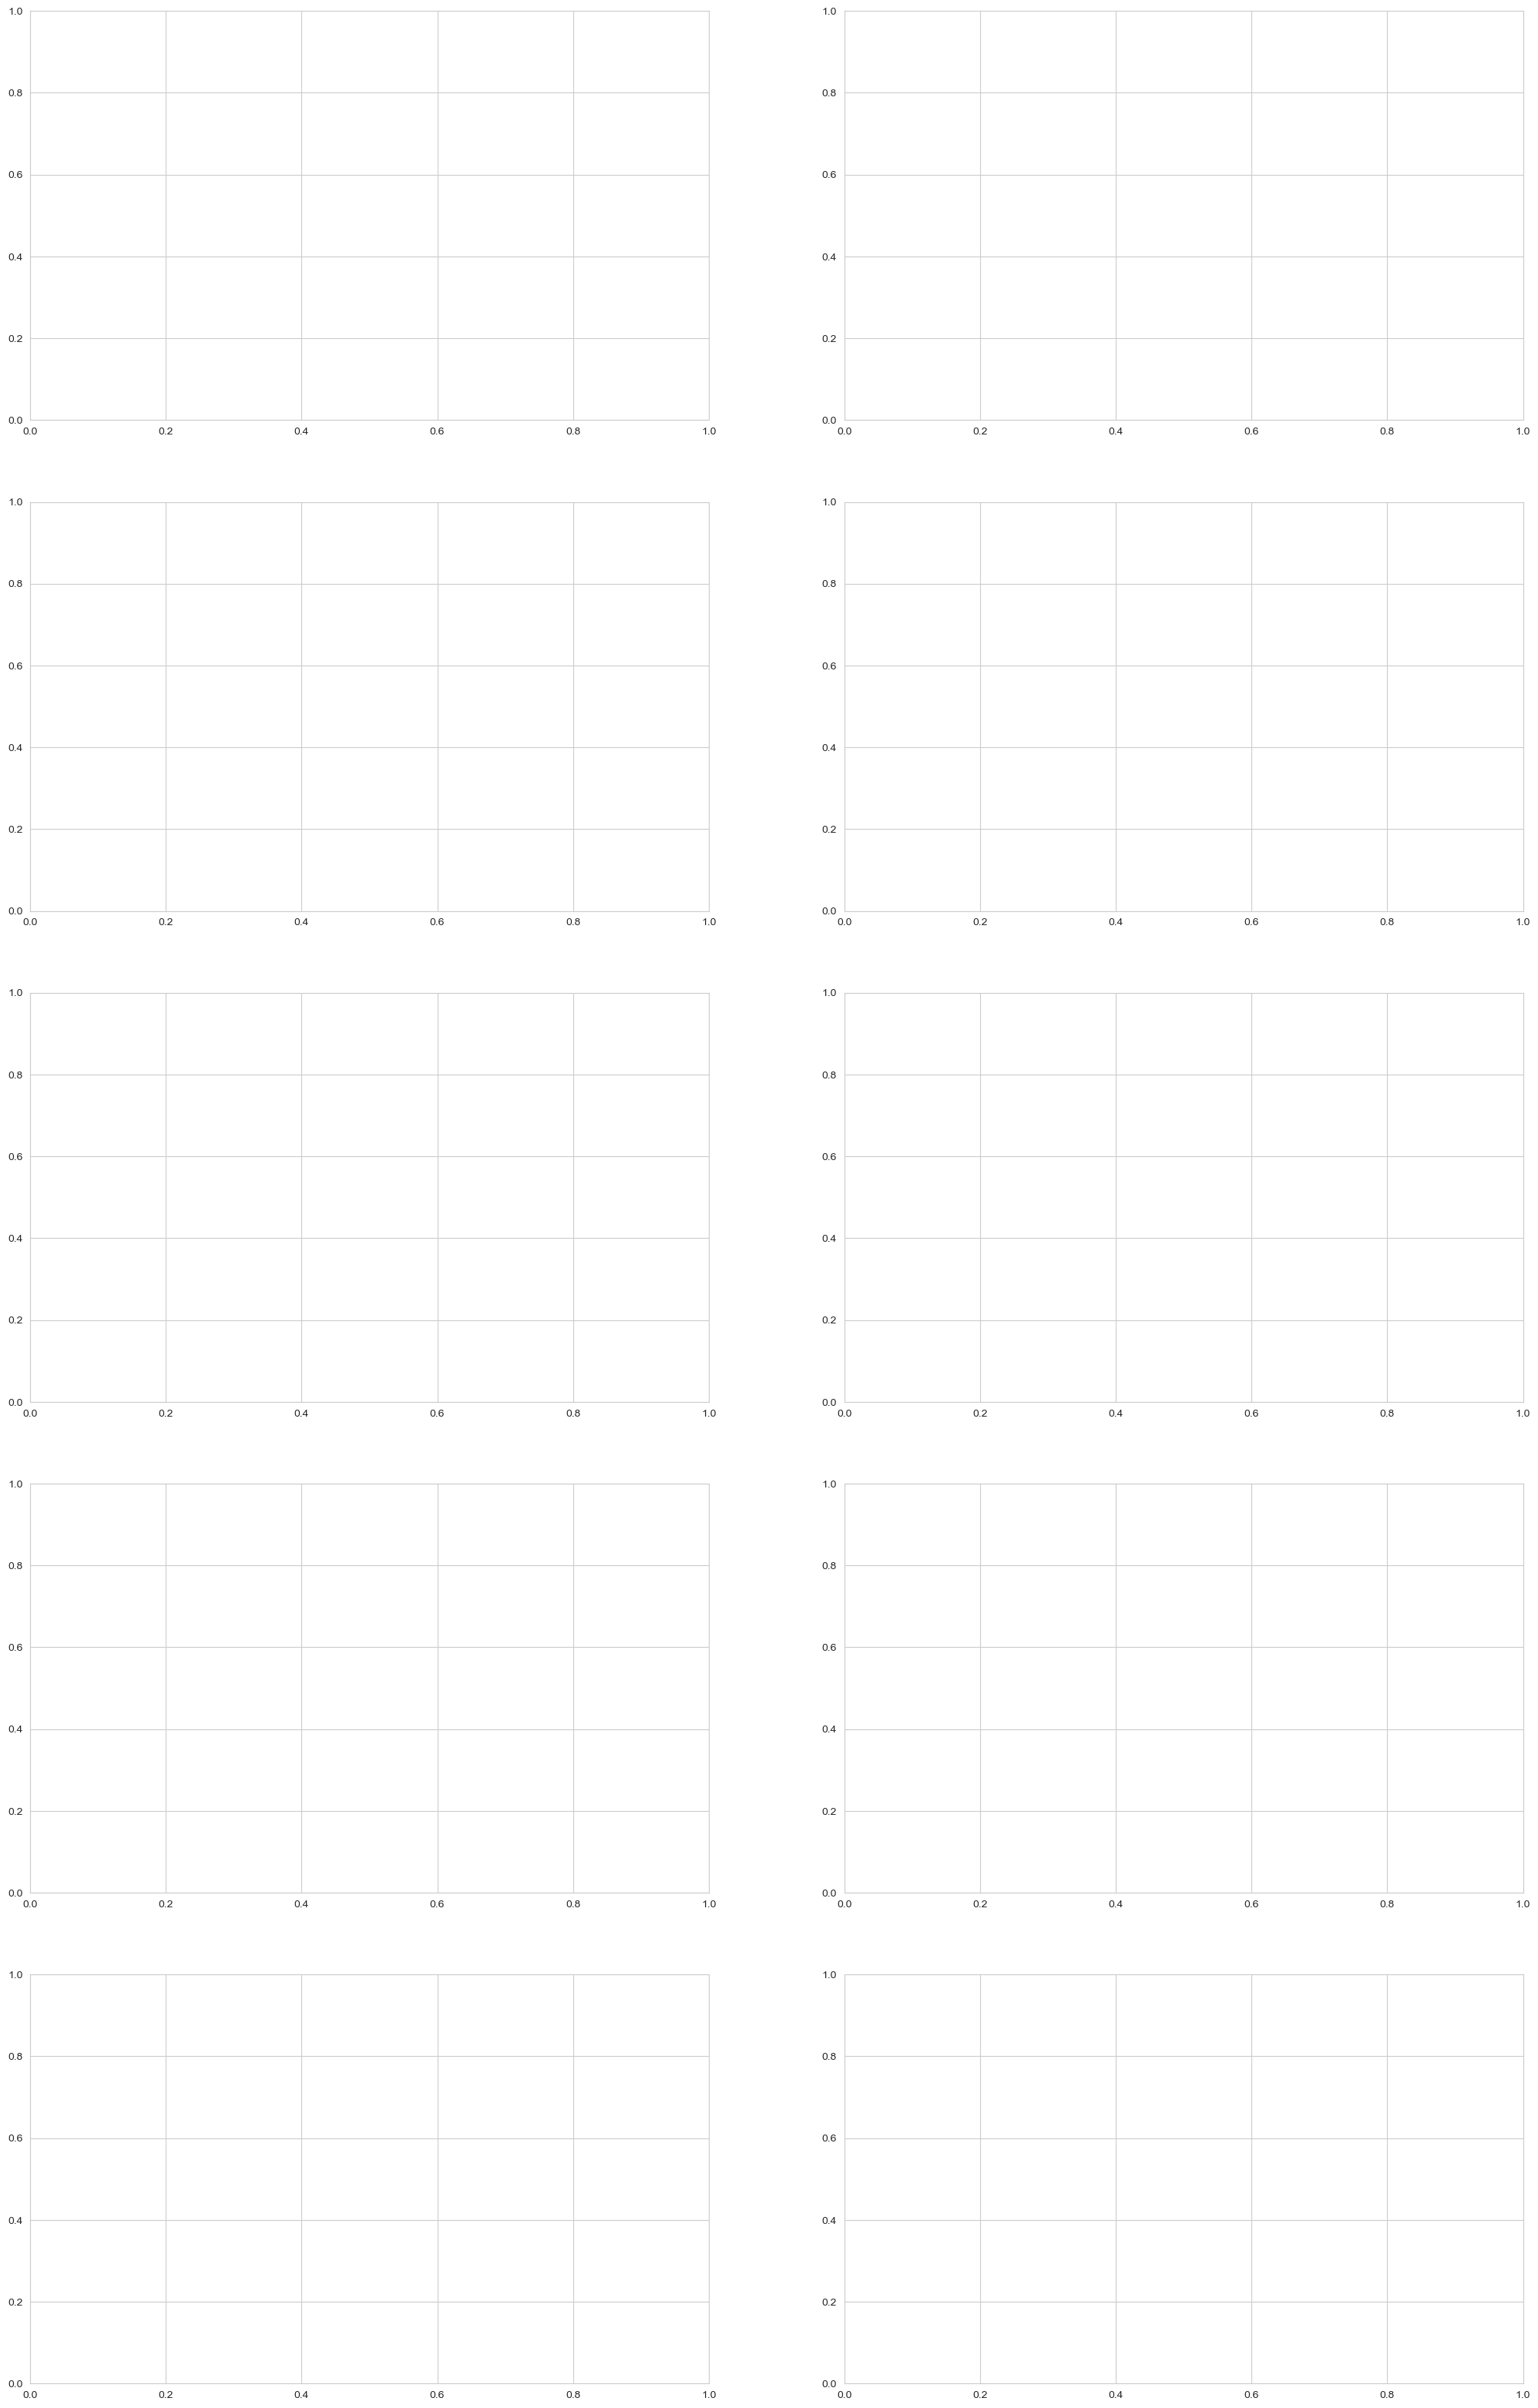

In [23]:
gamma = np.zeros(len(regions_id))
fig, axes = plt.subplots(5, 2, figsize=(25, 40))
axes = axes.reshape((-1))

error_s = []

for i, id in enumerate(regions_id):
    df = data_region[id]
    df = df.iloc[::-1]
    X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
    y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

    LR = LinearRegression(fit_intercept=False)
    LR.fit(X, y)

    sc = LR.score(X, y)
    error_s.append(sc)
    '''y_pred = LR.predict(X)
    y_pred -= gamma[i] * np.array(df['cum']).reshape((-1, 1))
    y -= gamma[i] * np.array(df['cum']).reshape((-1, 1))

    axes[i].plot(range(len(df)), y, label='ture vaccination')
    axes[i].plot(range(len(df)), y_pred, label='predicted vaccination')
    axes[i].set_title(regions_name[id] + " {}".format(sc))
    axes[i].legend()'''

In [23]:
#对新增和累计求    7日平均
for id in regions_id:
    for i in range(data_region[id].shape[0] - 6):
        #print(data_region[id].iloc[i:i + 7, 2].sum() / 7.0)
        #print(data_region[id].iloc[i:i + 7, 3].sum() / 7.0)
        data_region[id].iloc[i, 4] = data_region[id].iloc[i:i + 7, 4].sum() / 7.0
        data_region[id].iloc[i, 5] = data_region[id].iloc[i:i + 7, 5].sum() / 7.0
    data_region[id] = data_region[id].iloc[:-6]
data_region[regions_id[0]]

,name,code,date,reg,cum,new
3825,North East,E12000001,2023-01-11,2107351.0,2.004051e+06,22.734694
3826,North East,E12000001,2023-01-10,2107339.0,2.004028e+06,23.346939
3827,North East,E12000001,2023-01-09,2107317.0,2.004005e+06,23.612245
3828,North East,E12000001,2023-01-08,2107312.0,2.003981e+06,22.428571
3829,North East,E12000001,2023-01-07,2107301.0,2.003959e+06,21.224490
...,...,...,...,...,...,...
4573,North East,E12000001,2020-12-24,43954.0,5.133469e+02,4.408163
4574,North East,E12000001,2020-12-23,42481.0,5.089388e+02,4.530612
4575,North East,E12000001,2020-12-22,35560.0,5.044082e+02,4.551020
4576,North East,E12000001,2020-12-21,30424.0,4.998571e+02,4.367347


In [24]:
years = list(reversed(list(data_region[regions_id[0]]["date"])))
new_df = pd.DataFrame(index=years)
new_new_df = pd.DataFrame(index=years)
cum_df = pd.DataFrame(index=years)
log_df = pd.DataFrame(index=years)
reg_df = pd.DataFrame(index=years)
train_df = pd.DataFrame(index=years)
train_new_df = pd.DataFrame(index=years)
pred_df = pd.DataFrame(index=years)

753


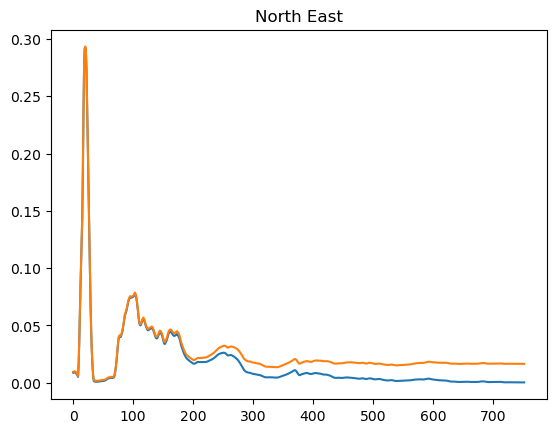

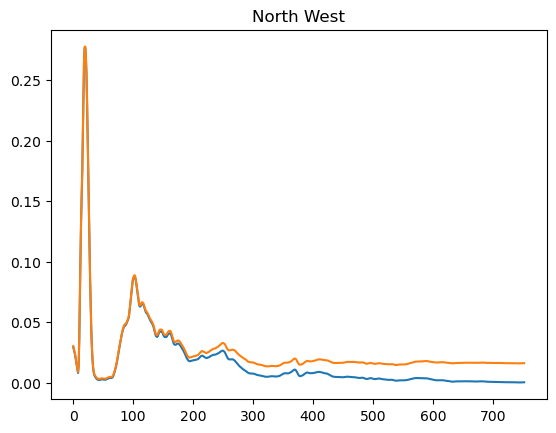

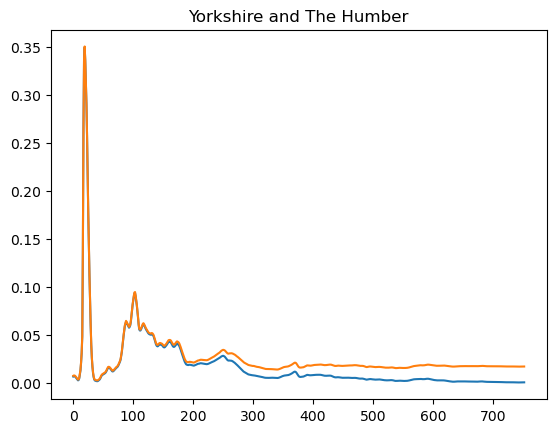

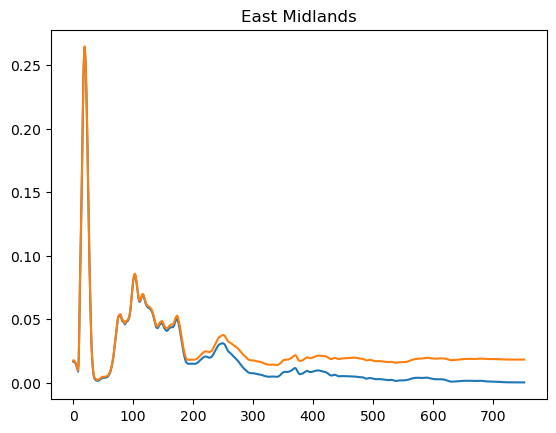

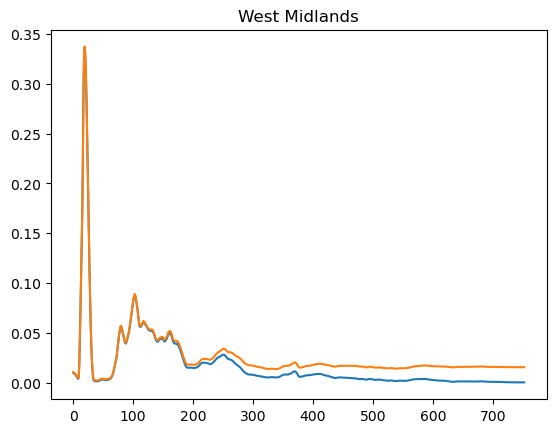

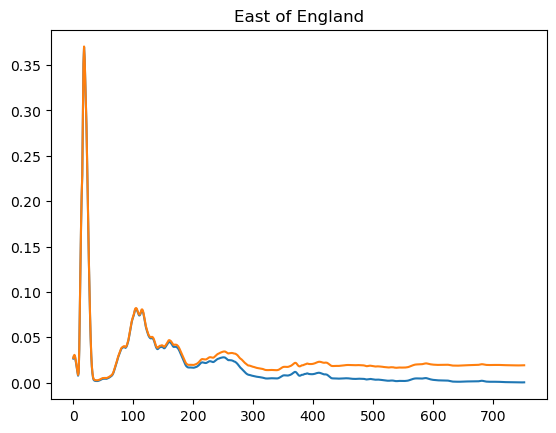

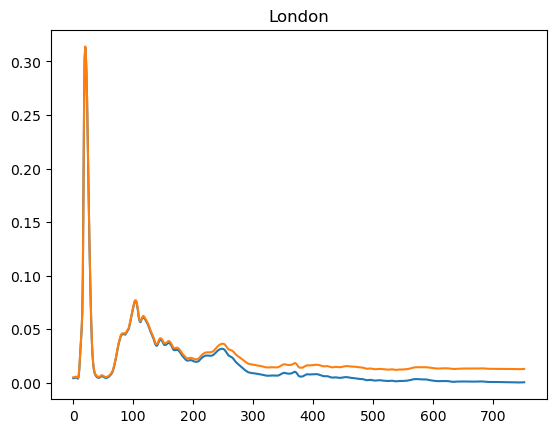

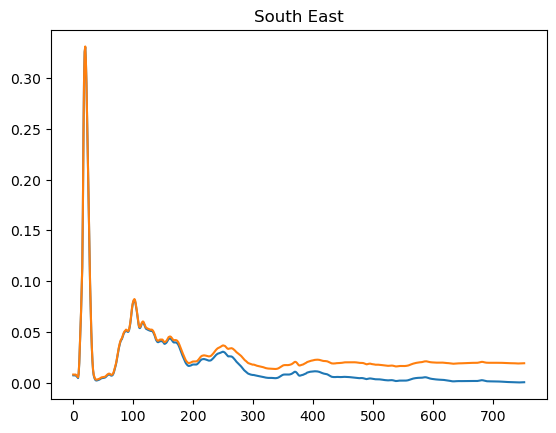

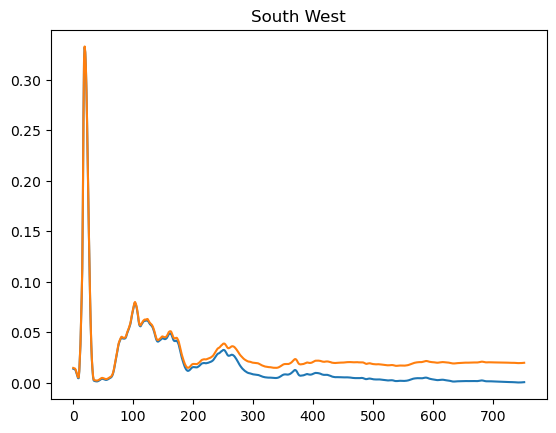

In [25]:
for i, id in enumerate(regions_id):
    #print(data_region[id]["newPeopleVaccinatedFirstDoseByVaccinationDate"])
    new_df[id] = list(reversed(list(data_region[id]["new"])))
    cum_df[id] = list(reversed(list(data_region[id]["cum"])))

    new_new_df[id] = [new_df[id][x] + gamma[i] * cum_df[id][x] for x in range(len(cum_df))]
    reg_df[id] = list(reversed(list(data_region[id]["reg"])))
    log_df[id] = np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    train_df[id] = new_df[id] / log_df[id]

    train_new_df[id] = new_new_df[id] / log_df[id]

print(len(train_df))

for id in regions_id:
    ri = np.array(train_df[id])
    ri_new = np.array(train_new_df[id])
    plt.title(regions_name[id])
    plt.plot(range(len(ri)), ri)
    plt.plot(range(len(ri_new)), ri_new)
    plt.show()

In [26]:
train_new_df.shape

(753, 9)

In [27]:
y = torch.from_numpy(np.array(train_new_df).reshape((-1, 9, 1)) * 100)
x = torch.unsqueeze(torch.linspace(-0.1, 0.9, len(y)), dim=1)

new = torch.from_numpy(np.array(new_df).reshape((-1, 9, 1)))
stat = torch.from_numpy(np.array(log_df).reshape((-1, 9, 1)))

index = [i for i in range(len(y))]
random.shuffle(index)
yi = y[index]
xi = x[index]

In [28]:
#模型定义
class draftSti(nn.Module):

    def __init__(self, n):
        super(draftSti, self).__init__()
        Anp = np.zeros((n, n))
        phinp = np.zeros((n, 1))
        itanp = np.zeros((n, 1))
        self.A = nn.Parameter(torch.from_numpy(Anp), requires_grad=True)
        #self.phi = nn.Parameter(torch.from_numpy(phinp), requires_grad=True)
        self.ita = nn.Parameter(torch.from_numpy(itanp), requires_grad=True)

    def forward(self, t):
        out = self.A * t
        out = torch.mm(torch.exp(out), self.ita)
        out = torch.add(out, self.ita)

        return out

In [29]:
#模型定义
class draftSingle(nn.Module):

    def __init__(self, n):
        super(draftSingle, self).__init__()
        Anp = np.ones((n))
        itanp = np.zeros((n, 1))
        self.A = nn.Parameter(torch.from_numpy(Anp), requires_grad=True)
        self.ita = nn.Parameter(torch.from_numpy(itanp), requires_grad=True)
        #self.phi = nn.Parameter(torch.from_numpy(itanp), requires_grad=True)

    def forward(self, t):
        out = torch.diag(self.A) * t
        out = torch.mm(torch.exp(out), self.ita)
        out = torch.add(out, self.ita)

        return out

net_bla=net

In [30]:
net = draftSti(9)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
loss_func = torch.nn.MSELoss()

net.load_state_dict(torch.load("_" + str(40000)))

<All keys matched successfully>

In [21]:


loss_list = []
leng = 200
all_leng = 759
rec = 0
for k in range(2001):

    if k % 100 == 0:
        torch.save(net.state_dict(), "_" + str(k))
        print(k, rec)

    for i in range(leng):

        #print(net.A.data)
        if i >= leng:
            idx = i % leng
        else:
            idx = i

        xt = xi[idx].to(torch.float64)
        yt = yi[idx].to(torch.float64)

        prediction = net(xt)
        loss = loss_func(prediction, yt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rec = loss.detach().numpy()

    '''test_loss = 0

    for j in range(leng, all_leng):
        add_loss = loss_func(net(xi[j].to(torch.float64)), yi[j].to(torch.float64)).detach().numpy()
        test_loss += add_loss

    test_loss /= all_leng - leng
    loss_list.append(float(rec))'''

print(net.A.data)
print(net.ita.data)

0 0
100 0.15054545595189012
200 0.15054545595189012
300 0.15054545595189012


KeyboardInterrupt: 

In [26]:
pd.DataFrame(np.array(net.A.detach().numpy()),
             index=[regions_name[id] for id in regions_id],
             columns=[regions_name[id] for id in regions_id])

,North East,North West,Yorkshire and The Humber,East Midlands,West Midlands,East of England,London,South East,South West
North East,-7.699537,-7.702938,-7.711914,-7.806054,-29.072166,-7.716199,-29.729070,-53.796387,-29.569311
North West,-7.750982,-7.754814,-7.763153,-7.855883,-29.256247,-7.766574,-29.845938,-53.669752,-29.673960
Yorkshire and The Humber,-8.003503,-8.006364,-8.014809,-8.113752,-29.880500,-8.019685,-30.610185,-54.643250,-30.418117
East Midlands,-8.534264,-8.540068,-8.553153,-8.733835,1.024689,-8.554807,-39.924057,-57.848902,-39.665119
West Midlands,0.588346,-3.578572,-3.580173,-3.594302,-25.491055,-3.585046,-25.898424,-52.803029,-25.788011
East of England,-7.618466,-7.620530,-7.627954,-7.749632,-31.524848,-7.630302,-32.197415,-56.235539,-31.912149
London,-4.333626,-4.327667,-4.328515,-0.953421,-22.035003,-4.336541,-22.331684,-50.218385,-22.315813
South East,-7.821330,-7.825606,-7.834913,-7.925685,-29.213601,-7.839462,-29.903540,-54.237871,-29.744958
South West,0.689553,-3.257092,-3.257455,-3.242044,-24.632082,-3.263182,-25.010146,-52.176177,-24.933117


In [27]:
pd.DataFrame(np.array(net.ita.detach().numpy()),
             index=[regions_name[id] for id in regions_id])

,0
North East,0.783364
North West,0.861561
Yorkshire and The Humber,0.913632
East Midlands,3.515149
West Midlands,-1.630972
East of England,0.908197
London,-1.923372
South East,0.941462
South West,-1.809672


In [99]:
t = pd.DataFrame(-np.absolute(net.A.detach().numpy()).round(3),
                 index=[regions_name[id] for id in regions_id],
                 columns=[regions_name[id] for id in regions_id]).to_latex()
print(t)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  North East &  North West &  Yorkshire and The Humber &  East Midlands &  West Midlands &  East of England &  London &  South East &  South West \\
\midrule
North East               &      -5.486 &      -5.675 &                    -0.577 &         -5.771 &         -5.357 &           -4.575 &  -3.019 &      -4.627 &      -4.469 \\
North West               &      -6.334 &      -6.298 &                    -0.689 &         -7.395 &         -7.498 &           -4.308 &  -3.784 &      -3.953 &      -3.923 \\
Yorkshire and The Humber &      -2.625 &      -2.658 &                    -1.291 &         -2.677 &         -2.627 &           -2.462 &  -2.083 &      -2.482 &      -2.446 \\
East Midlands            &      -5.264 &      -5.260 &                    -0.909 &         -5.223 &         -5.099 &           -5.188 &  -4.741 &      -5.057 &      -5.040 \\
West Midlands            &      -5.374 &      -5.408 &                    -0.828 &         -5.406 &  

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_29218/1010882801.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  t=pd.DataFrame(-np.absolute(net.A.detach().numpy()).round(3),


In [100]:
t = pd.DataFrame(np.absolute(net.ita.detach().numpy()),
                 index=[regions_name[id] for id in regions_id]).to_latex()
print(t)

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
North East               &  0.922129 \\
North West               &  1.032668 \\
Yorkshire and The Humber &  0.535658 \\
East Midlands            &  1.166693 \\
West Midlands            &  1.089289 \\
East of England          &  0.557226 \\
London                   &  0.161133 \\
South East               &  0.672224 \\
South West               &  0.604747 \\
\bottomrule
\end{tabular}


/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_29218/66245542.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  t=pd.DataFrame(np.absolute(net.ita.detach().numpy()),


In [31]:
len(train_df)

y_pred = []
for i in x:
    y_pred.append(net(i).detach().numpy())
y_pred = np.array(y_pred)
y_pred

array([[[ 1.08922643e+02],
        [ 1.05513724e+02],
        [ 1.18086668e+02],
        ...,
        [ 9.41258184e+01],
        [ 1.16349639e+02],
        [ 1.09315104e+02]],

       [[ 9.91865322e+01],
        [ 9.60275823e+01],
        [ 1.07366325e+02],
        ...,
        [ 8.67049762e+01],
        [ 1.05976270e+02],
        [ 1.00207187e+02]],

       [[ 9.02346196e+01],
        [ 8.73077231e+01],
        [ 9.75229398e+01],
        ...,
        [ 7.98127348e+01],
        [ 9.64404708e+01],
        [ 9.17802125e+01]],

       ...,

       [[ 7.83589264e-01],
        [ 8.60383613e-01],
        [ 9.11929691e-01],
        ...,
        [-3.30272727e-01],
        [ 9.17605329e-01],
        [ 5.07005561e-03]],

       [[ 7.83519873e-01],
        [ 8.60317346e-01],
        [ 9.11875268e-01],
        ...,
        [-3.32570807e-01],
        [ 9.17542090e-01],
        [ 5.04655646e-03]],

       [[ 7.83451191e-01],
        [ 8.60251762e-01],
        [ 9.11821423e-01],
        ...,
        

import pickle

pickle.dump(y_pred, open('./y_pred_2nd.pkl', 'wb'))

In [47]:
import pickle

y_pred = pickle.load(open('./y_pred_2nd.pkl', 'rb'))

In [33]:
from sklearn.metrics import r2_score

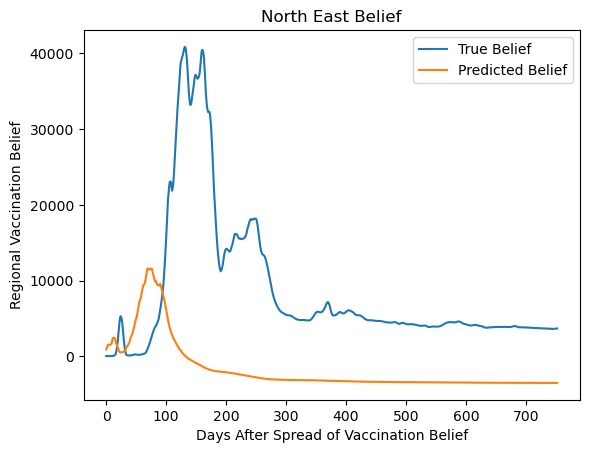

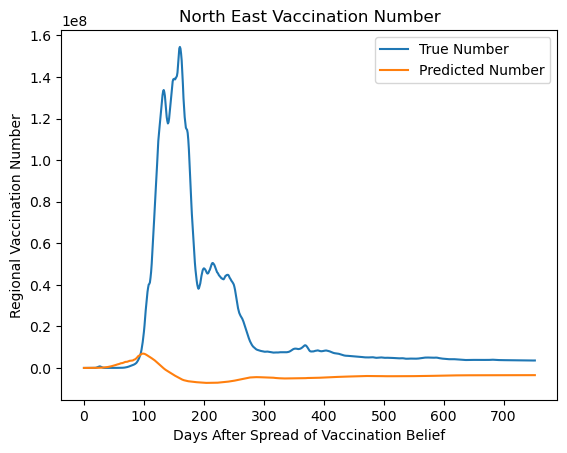

IndexError: index 1 is out of bounds for axis 1 with size 1

In [39]:
sc_s = []
for i in range(9):
    y_t = np.array(y[:, i]).reshape((-1))
    y_p = np.array(y_pred[:, i]).reshape((-1))

    id = regions_id[i]
    plt.title(regions_name[id] + " Belief")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Belief")
    plt.plot(range(len(x)), y_t, label="True Belief")
    plt.plot(range(len(x)), y_p, label="Predicted Belief")
    plt.legend()
    plt.show()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    plt.title(regions_name[id] + " Vaccination Number")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Number")
    plt.plot(range(len(x)), true_end, label="True Number")
    plt.plot(range(len(x)), pred_end, label="Predicted Number")
    sc_s.append(r2_score(true_end, pred_end))
    plt.legend()
    plt.show()

In [38]:
mns = [regions_name[id] for id in regions_id]
sc_s = [x for x in sc_s]
t = pd.DataFrame({
    'Name': mns,
    'SIR Model':sc_sir,
    'Network Model': sc_s
}).to_latex()
print(t)

\begin{tabular}{llrr}
\toprule
{} &                      Name &  SIR Model &  Network Model \\
\midrule
0 &                North East &  -0.786841 &      -0.786841 \\
1 &                North West &  -0.799063 &      -0.799063 \\
2 &  Yorkshire and The Humber &  -0.798008 &      -0.798008 \\
3 &             East Midlands &  -0.737425 &      -0.737425 \\
4 &             West Midlands &  -0.779290 &      -0.779290 \\
5 &           East of England &  -0.783746 &      -0.783746 \\
6 &                    London &  -1.011724 &      -1.011724 \\
7 &                South East &  -0.833458 &      -0.833458 \\
8 &                South West &  -0.748919 &      -0.748919 \\
\bottomrule
\end{tabular}


/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_23992/3958298699.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  t = pd.DataFrame({


fig, axes = plt.subplots(3, 2, figsize=(15, 18))
for i in range(3)[:]:
    y_t = np.array(y[:, i]).reshape((-1))
    y_p = np.array(y_pred[:, i]).reshape((-1))

    id = regions_id[i]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(15, 24))
for i in range(4)[:]:
    y_t = np.array(y[:, i + 3]).reshape((-1))
    y_p = np.array(y_pred[:, i + 3]).reshape((-1))

    id = regions_id[i + 3]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i in range(2)[:]:
    y_t = np.array(y[:, i + 7]).reshape((-1))
    y_p = np.array(y_pred[:, i + 7]).reshape((-1))

    id = regions_id[i + 7]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(25, 40))
for i in range(4)[:]:
    y_t = np.array(y[:, i + 5]).reshape((-1))
    y_p = np.array(y_pred[:, i + 5]).reshape((-1))

    id = regions_id[i + 5]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

In [70]:
net_comp = draftSingle(9)
optimizer = torch.optim.SGD(net_comp.parameters(), lr=1e-2)
loss_func = torch.nn.MSELoss()

In [71]:
loss_list = []
leng = 200
all_leng = 759
rec = 0
for k in range(2001):

    if k % 100 == 0:
        #torch.save(net.state_dict(), "_" + str(k))
        print(k, rec)

    for i in range(leng):

        #print(net.A.data)
        if i >= leng:
            idx = i % leng
        else:
            idx = i

        xt = xi[idx].to(torch.float64)
        yt = yi[idx].to(torch.float64)

        prediction = net_comp(xt)
        loss = loss_func(prediction, yt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rec = loss.detach().numpy()

    '''test_loss = 0

    for j in range(leng, all_leng):
        add_loss = loss_func(net(xi[j].to(torch.float64)), yi[j].to(torch.float64)).detach().numpy()
        test_loss += add_loss

    test_loss /= all_leng - leng
    loss_list.append(float(rec))'''

print(net_comp.A.data)
print(net_comp.ita.data)

0 0
100 109.30823164986417
200 98.36543381956545
300 90.77146030006764
400 85.35312002970454
500 81.65708504381456
600 79.29196293076292
700 77.86190642363194
800 77.03370034475137
900 76.57199296174831
1000 76.3257550184853
1100 76.2026336407227
1200 76.14775329080437
1300 76.12924666059767
1400 76.12903265788833
1500 76.137127158508
1600 76.14820976554537
1700 76.15959071149128
1800 76.17002804354246
1900 76.17905145036234
2000 76.18658284585852
tensor([  1.4931,   1.5301,   1.3531, -25.0166, -23.6431, -24.1290,   1.4311,
        -24.2371, -24.6042], dtype=torch.float64)
tensor([[-0.4567],
        [-0.4295],
        [-0.5283],
        [ 1.2458],
        [ 1.4855],
        [ 1.7905],
        [-0.4881],
        [ 1.2256],
        [ 1.1663]], dtype=torch.float64)


In [74]:
len(train_df)

y_pred = []
for i in x:
    y_pred.append(net_comp(i).detach().numpy())
y_pred = np.array(y_pred)

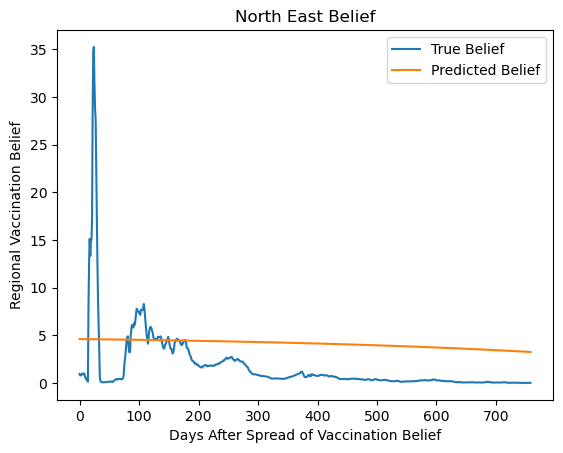

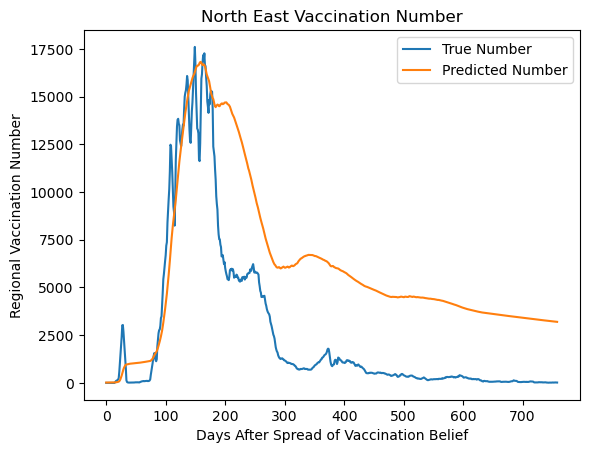

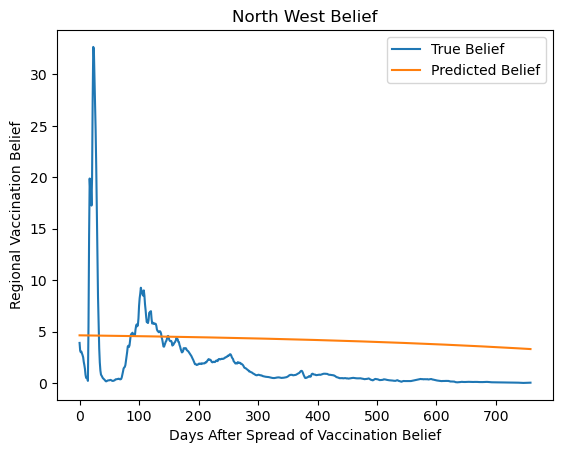

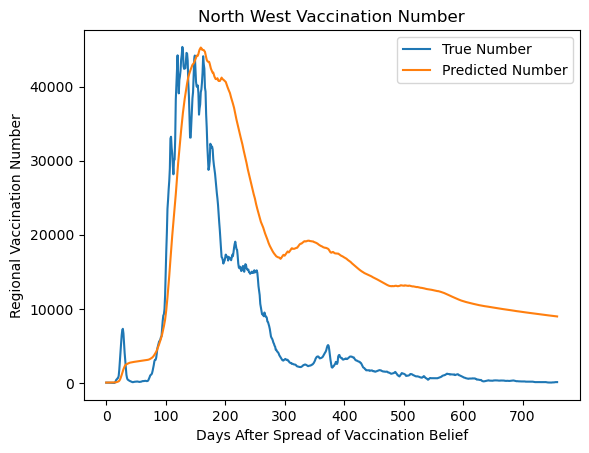

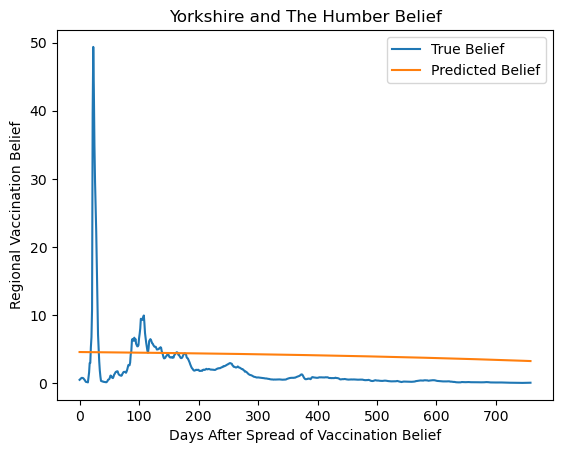

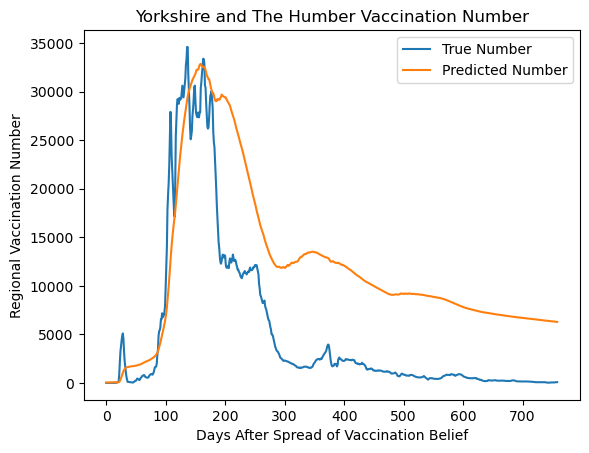

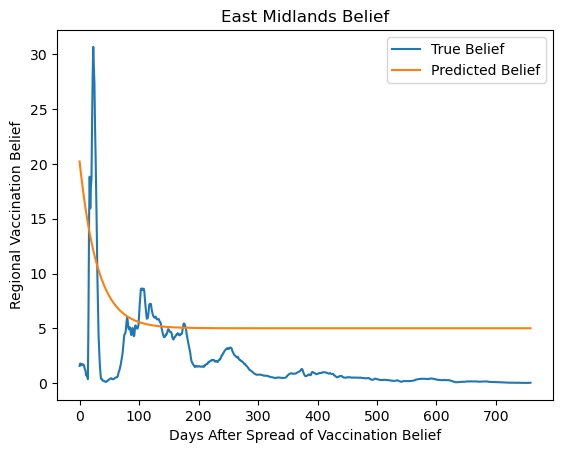

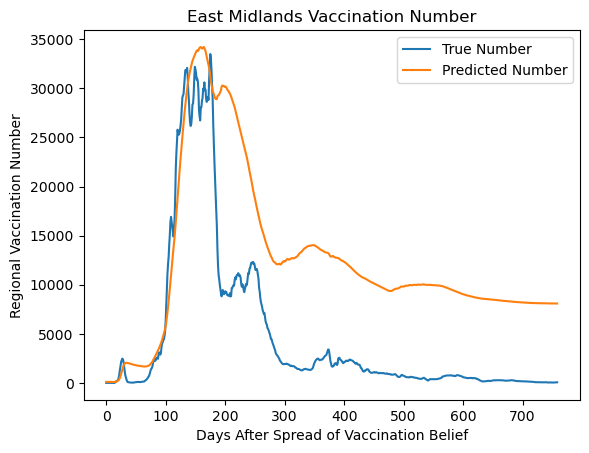

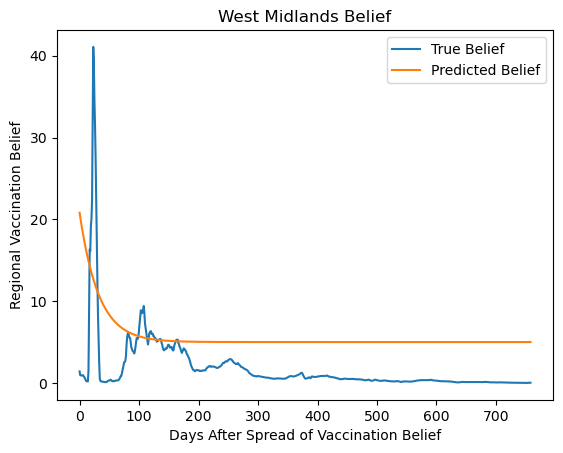

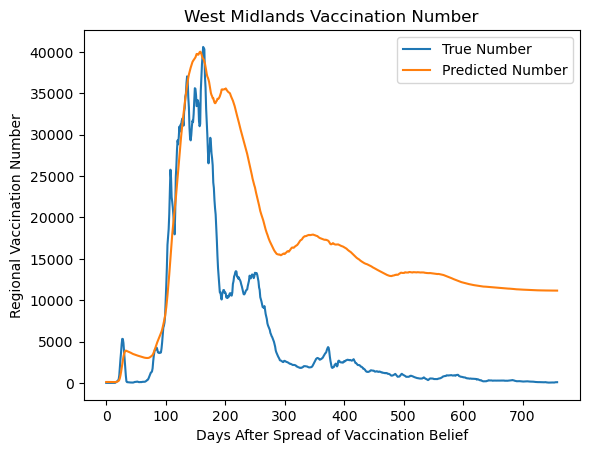

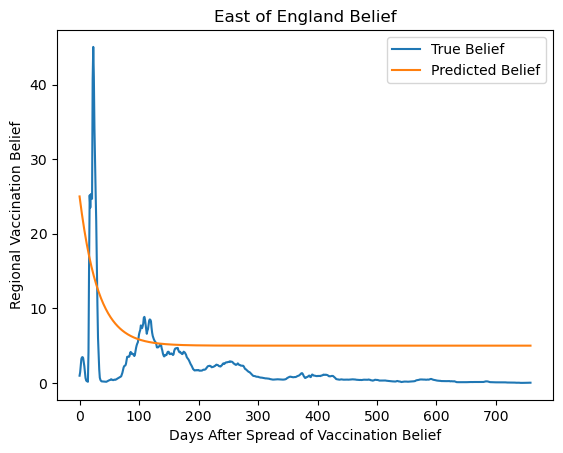

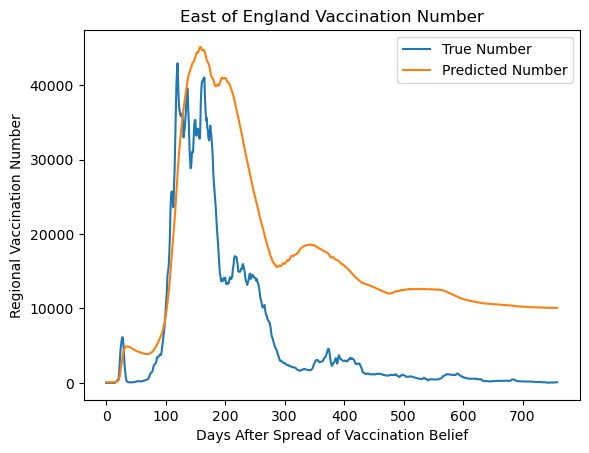

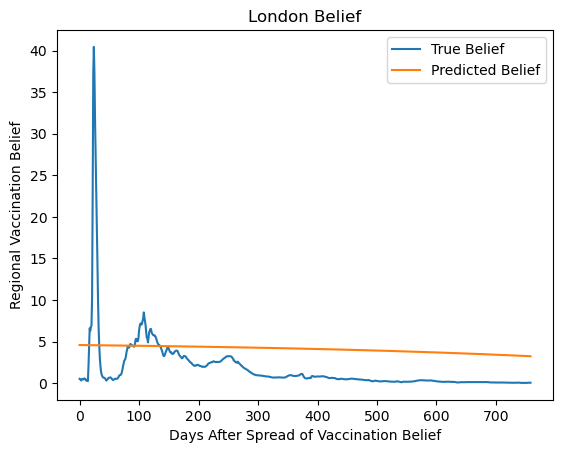

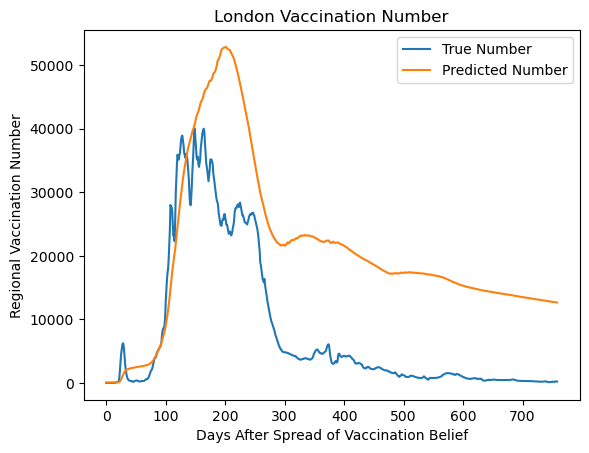

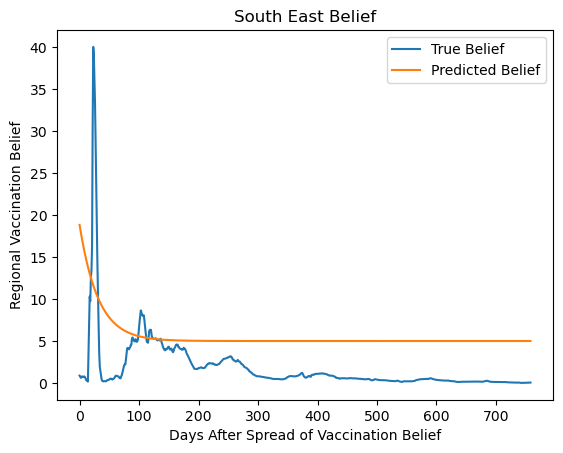

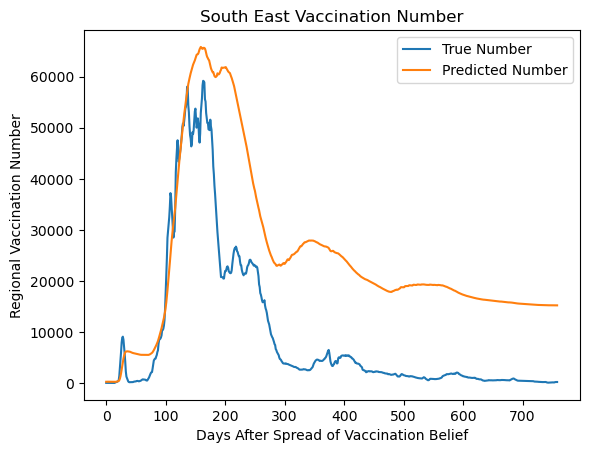

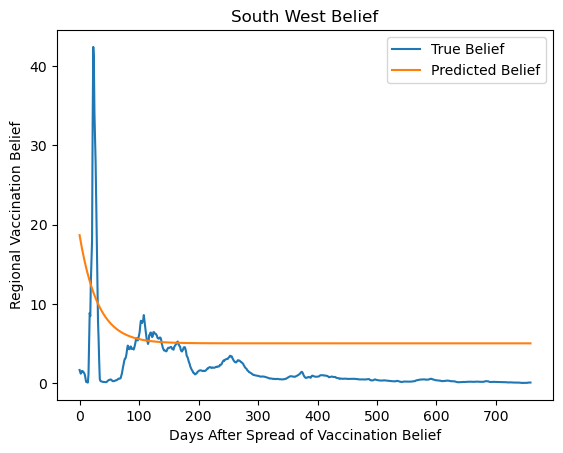

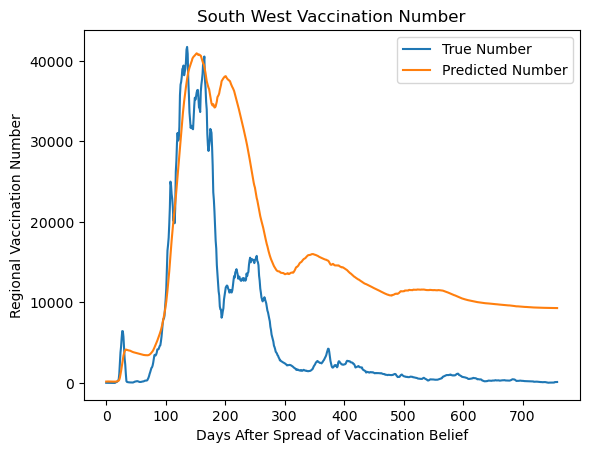

In [75]:
for i in range(9):
    y_t = np.array(y[:, i]).reshape((-1))
    y_p = np.array(y_pred[:, i]).reshape((-1))

    id = regions_id[i]
    plt.title(regions_name[id] + " Belief")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Belief")
    plt.plot(range(len(x)), y_t, label="True Belief")
    plt.plot(range(len(x)), y_p, label="Predicted Belief")
    plt.legend()
    plt.show()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    plt.title(regions_name[id] + " Vaccination Number")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Number")
    plt.plot(range(len(x)), true_end, label="True Number")
    plt.plot(range(len(x)), pred_end, label="Predicted Number")
    plt.legend()
    plt.show()

In [ ]:
rg_names = []
for i in regions_id:
    rg_names.append(regions_name[i])

In [ ]:
pd.DataFrame([[-10.7596, -10.7596, -10.7596, -10.7596, -10.7596, -10.7596, -10.7596,
               -10.7596, -10.7596],
              [-10.2862, -10.2862, -10.2862, -10.2862, -10.2862, -10.2862, -10.2862,
               -10.2862, -10.2862],
              [-11.0944, -11.0944, -11.0944, -11.0944, -11.0944, -11.0944, -11.0944,
               -11.0944, -11.0944],
              [-9.6007, -9.6007, -9.6007, -9.6007, -9.6007, -9.6007, -9.6007,
               -9.6007, -9.6007],
              [-11.2211, -11.2211, -11.2211, -11.2211, -11.2211, -11.2211, -11.2211,
               -11.2211, -11.2211],
              [-10.3126, -10.3126, -10.3126, -10.3126, -10.3126, -10.3126, -10.3126,
               -10.3126, -10.3126],
              [-10.2468, -10.2468, -10.2468, -10.2468, -10.2468, -10.2468, -10.2468,
               -10.2468, -10.2468],
              [-10.5677, -10.5677, -10.5677, -10.5677, -10.5677, -10.5677, -10.5677,
               -10.5677, -10.5677],
              [-10.6959, -10.6959, -10.6959, -10.6959, -10.6959, -10.6959, -10.6959,
               -10.6959, -10.6959]], columns=rg_names, index=rg_names)

In [ ]:
pd.DataFrame({
    "names": rg_names,
    "": [-0.2272,
         -0.2568,
         -0.2047,
         -0.2501,
         -0.2339,
         -0.2112,
         -0.2414,
         -0.2187,
         -0.2120]})

In [ ]:
import networkx as nx

In [ ]:
G = nx.complete_graph(9)


In [ ]:
nm = {}
lm = {}
for i, n in enumerate(['North East',
                       'North West',
                       'South West',
                       'E.Midlands',
                       'W. Midlands',
                       'London',
                       'E. England',
                       'South East',
                       'Yorkshire']):
    nm[i] = {'name': n}
    lm[i] = n
#nx.set_node_attributes(G, nm)

In [ ]:
A = pd.read_csv('./matrix_with_7021.csv')
np.array(A)

In [ ]:

G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)
layout = nx.spring_layout(G)
print(layout)

In [ ]:
plt.figure(figsize=(25, 20))
nx.draw_networkx_edges(G, layout, width=[float(d['weight'] * 0.03) for (u, v, d) in G.edges(data=True)], arrows=True,
                       connectionstyle="arc3,rad=0.3")
nx.draw_networkx_nodes(G, layout, node_size=100)
nx.draw_networkx_labels(G, layout, labels=lm, font_size=20, verticalalignment='top', horizontalalignment='left')
#nx.draw_networkx(G, labels=lm, with_labels=True)
plt.savefig('./nt.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
layout = nx.spring_layout(G)
nx.draw_networkx(G, layout)
nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, labels=lm, with_labels=True)

In [ ]:
import pandas as pd

df = pd.read_csv("./matrix_with_9974.csv")
df.columns = ['North East',
              'North West',
              'South West',
              'East Midlands',
              'West Midlands',
              'London',
              'East of England',
              'South East',
              'Yorkshire & Humber']
df.index = ['North East',
            'North West',
            'South West',
            'East Midlands',
            'West Midlands',
            'London',
            'East of England',
            'South East',
            'Yorkshire & Humber']

In [ ]:
df = df.round(3)
df.to_csv('./table.csv')